In [1]:
import os
import glob
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import timm  # for using vision transformer models


In [2]:
def build_dataframe_subset(root_dir, label_map, folder_list=None):
    """
    Scans root_dir for image files (png, jpg, jpeg) within a subset of folders and assigns
    labels based on the subfolder name if it contains a key from label_map.
    
    Parameters:
      root_dir (str): The root directory of your dataset.
      label_map (dict): A mapping where each key (e.g., 'real', 'fake') is a substring
                        to search for in the folder name and its value is the corresponding label.
      folder_list (list, optional): List of specific folder names to include. If None,
                                    the first three subdirectories (alphabetically) are used.
                        
    Returns:
      DataFrame: A DataFrame with columns ['image_path', 'label'].
    """
    # Get the list of subfolders in the root_dir
    all_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    if folder_list is None:
        # Use the first three subfolders (alphabetically sorted)
        folder_list = sorted(all_folders)[:3]
    else:
        # Ensure the provided folder_list exists in the directory
        folder_list = [f for f in folder_list if f in all_folders]
        
    print("Using folders:", folder_list)

    image_paths = []
    labels = []
    # Process only the specified folders
    for folder in folder_list:
        folder_path = os.path.join(root_dir, folder)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)
                image_paths.append(img_path)
                # Use the folder name to decide the label.
                folder_lower = folder.lower()
                label = None
                for key, val in label_map.items():
                    if key in folder_lower:
                        label = val
                        break
                if label is None:
                    # Option: if no matching key, assign a default label (e.g., 0)
                    label = 0
                labels.append(label)
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df

# For example, if your folder names contain 'real' or 'fake':
label_map = {'real': 0, 'fake': 1}
# Specify your dataset root folder:
root_dataset_dir = '/kaggle/input/deepfake-detection-faces-part-0-0'

# Option 1: Automatically use the first three folders:
df_all = build_dataframe_subset(root_dataset_dir, label_map, folder_list=None)
# Option 2: Or manually specify folder names (uncomment and adjust if needed):
# df_all = build_dataframe_subset(root_dataset_dir, label_map, folder_list=['folder1', 'folder2', 'folder3'])

print(df_all.head())


Using folders: ['aaqaifqrwn', 'abhggqdift', 'acdkfksyev']
                                          image_path  label
0  /kaggle/input/deepfake-detection-faces-part-0-...      0
1  /kaggle/input/deepfake-detection-faces-part-0-...      0
2  /kaggle/input/deepfake-detection-faces-part-0-...      0
3  /kaggle/input/deepfake-detection-faces-part-0-...      0
4  /kaggle/input/deepfake-detection-faces-part-0-...      0


In [3]:
class DeepFakeFlatDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        dataframe: a DataFrame with columns ['image_path', 'label']
        transform: torchvision transforms to be applied on the images
        """
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['image_path']
        label = row['label']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_all, test_size=0.2, stratify=df_all['label'], random_state=42)

train_dataset = DeepFakeFlatDataset(df_train, transform=transform)
val_dataset = DeepFakeFlatDataset(df_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


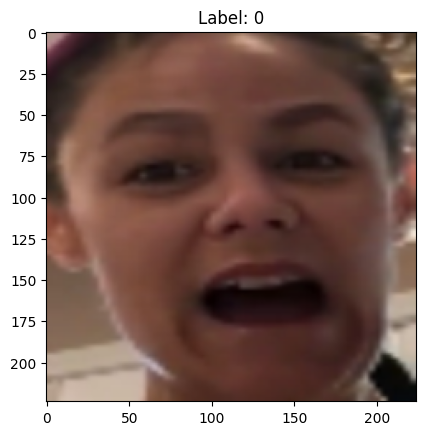

In [5]:
import matplotlib.pyplot as plt

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().transpose(1, 2, 0)
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

# Display the first image from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0], "Label: " + str(labels[0].item()))
